<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRA
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA: Recurrent Neural Networks

En esta práctica se implementará diferentes redes neuronales convolucionales para detectar el glaucoma.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# Autor: Mario Ubierna San Mamés

# Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. 

El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada
a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.

# Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la  exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

*   Diaz-Pinto, A., Morales, S., Naranjo, V. et al. CNNs for automatic glaucoma
assessment using fundus images: an extensive validation. BioMed Eng OnLine
18, 29 (2019). https://doi.org/10.1186/s12938-019-0649-y

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha
dividido en 10 particiones distintas que se usarán para aplicar un método de cross validation con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: train, test y valid. Las imágenes a su vez están etiquetadas de dos formas: normal o abnormal.




# Librerías

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import _pickle as pickle
from timeit import default_timer as timer

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from keras.models import load_model
import keras.backend as K

import matplotlib.pyplot as plt

# Carga de Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sección 1 - Análisis exploratorio de los datos

En este apartado se va a realizar diferentes análisis sobre los datos, así se conseguirá entender mejor la problemática que se busca resolver e idearemos un desarrollo para cumplir el objetivo del proyecto.

Pero antes de comenzar con eso hay que realizar la lectura de los datos:

## Lectura de los datos

In [3]:
# Método que carga una porción específica de los datos, según el fold y el tipo de dataset que queremos cargar
def load_dataset(fold="Fold0", dataset="train"):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  # Cargamos los datos
  df = pd.DataFrame()
  lstFilenames = []
  lstImages = []
  lstTarget = []

  # abnormal (1)
  for filename in os.listdir(os.path.join(root, fold, dataset, "abnormal")):
    lstFilenames.append(filename.split(".")[0]) # Sin .jpg
    lstImages.append(np.array(Image.open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/", fold, dataset, "abnormal", filename))))
    lstTarget.append(1)

  # normal (0)
  for filename in os.listdir(os.path.join(root, fold, dataset, "normal")):
    lstFilenames.append(filename.split(".")[0]) # Sin .jpg
    lstImages.append(np.array(Image.open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/", fold, dataset, "normal", filename))))
    lstTarget.append(0)

  # Devolvemos el resultado
  df = pd.DataFrame(data={
    "FileName": lstFilenames,
    "Image": lstImages,
    "Target": lstTarget
    })
  
  return df

In [4]:
# Método encargado de cargar todos los datos para un Fold
def load_data(fold="Fold0"):

  print("\n" + fold)
  
  # Cargamos el conjunto de train
  print("\tCargando el conjunto de train...")
  df_train = load_dataset(fold=fold, dataset="train")

  # Cargamos el conjunto de validación
  print("\tCargando el conjunto de valid...")
  df_valid = load_dataset(fold=fold, dataset="valid")

  # Cargamos el conjunto de test
  print("\tCargando el conjunto de test...")
  df_test = load_dataset(fold=fold, dataset="test")

  return df_train, df_valid, df_test

El siguiente paso es guardar los dataframes generados para así no tener que hacerlo cada vez:

In [5]:
def save_data_to_pickle(fold="Fold0", df_train=None, df_valid=None, df_test=None):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  print("\tGuardamos los conjuntos a formato pickle...")
  df_train.to_pickle(os.path.join(root, fold, "df_train.pickle"))
  df_valid.to_pickle(os.path.join(root, fold, "df_valid.pickle"))
  df_test.to_pickle(os.path.join(root, fold, "df_test.pickle"))

Realizamos la lectura dejamos programada la lectura de los ficheros pickle

In [6]:
def load_data_from_pickle(fold="Fold0"):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  df_train = pd.read_pickle(os.path.join(root, fold, "df_train.pickle"))
  df_valid = pd.read_pickle(os.path.join(root, fold, "df_valid.pickle"))
  df_test = pd.read_pickle(os.path.join(root, fold, "df_test.pickle"))

  return df_train, df_valid, df_test

In [ ]:
# df_train, df_valid, df_test = load_data_from_pickle(fold="Fold0")

Lo siguiente es hacer la lectura de todos los folds:

In [ ]:
FOLDS = 10

for nFold in range(FOLDS):
  # Obtenemos los datos en un dataframe
  df_train, df_valid, df_test = load_data(fold="Fold" + str(nFold))
  # Guardamos los datos a formato pickle
  save_data_to_pickle(fold="Fold" + str(nFold), df_train=df_train, df_valid=df_valid, df_test=df_test)


Fold0
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold1
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold2
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold3
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold4
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold5
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold6
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargan

Ahora hay que comprobar que todos los datos estén bien, es decir, que en cada conjunto estén las imágenes correspondientes y que el valor Target sea el que tiene que ser:

In [ ]:
# Método que se encarga de comprobar si la lectura está bien
def check_data(fold="Fold0", dataset="train", df=None):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  lstFilenames = df["FileName"].values

  # abnormal (1)
  for filename in os.listdir(os.path.join(root, fold, dataset, "abnormal")):

    filename = filename.split(".")[0] 
    # Comprobamos que está la imagen
    if not filename in lstFilenames:
      return False
    # Comprobamos que el target es el adecuado
    if df[df["FileName"] == filename]["Target"].item() != 1:
      return False

  # normal (0)
  for filename in os.listdir(os.path.join(root, fold, dataset, "normal")):

    filename = filename.split(".")[0] 
    # Comprobamos que está la imagen
    if not filename in lstFilenames:
      return False
    # Comprobamos que el target es el adecuado
    if df[df["FileName"] == filename]["Target"].item() != 0:
      return False
  
  return True

In [ ]:
for nFold in range(FOLDS):
  # Comprobamos la data para cada FOLD
  print("Fold" + str(nFold))
  print("\tLeemos los conjuntos de formato pickle...")
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))

  bTrain = check_data(fold="Fold" + str(nFold), dataset="train", df=df_train)
  print("\tTrain: " + str(bTrain))

  bValid = check_data(fold="Fold" + str(nFold), dataset="valid", df=df_valid)
  print("\tValid: " + str(bValid))

  bTest = check_data(fold="Fold" + str(nFold), dataset="test", df=df_test)
  print("\tTest: " + str(bTest))

Fold0
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold1
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold2
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold3
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold4
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold5
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold6
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold7
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold8
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold9
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True


## Análisis

Lo primero de todo es cargar todos los datos para cada uno de los folds, necearios para realizar la práctica:

In [7]:
# Fold0
print("Fold0")
print("\tLeemos los conjuntos de formato pickle...")
f0_df_train, f0_df_valid, f0_df_test = load_data_from_pickle(fold="Fold0")

# Fold1
print("Fold1")
print("\tLeemos los conjuntos de formato pickle...")
f1_df_train, f1_df_valid, f1_df_test = load_data_from_pickle(fold="Fold1")

# Fold2
print("Fold2")
print("\tLeemos los conjuntos de formato pickle...")
f2_df_train, f2_df_valid, f2_df_test = load_data_from_pickle(fold="Fold2")

# Fold3
print("Fold3")
print("\tLeemos los conjuntos de formato pickle...")
f3_df_train, f3_df_valid, f3_df_test = load_data_from_pickle(fold="Fold3")

# Fold4
print("Fold4")
print("\tLeemos los conjuntos de formato pickle...")
f4_df_train, f4_df_valid, f4_df_test = load_data_from_pickle(fold="Fold4")

# Fold5
print("Fold5")
print("\tLeemos los conjuntos de formato pickle...")
f5_df_train, f5_df_valid, f5_df_test = load_data_from_pickle(fold="Fold5")

# Fold6
print("Fold6")
print("\tLeemos los conjuntos de formato pickle...")
f6_df_train, f6_df_valid, f6_df_test = load_data_from_pickle(fold="Fold6")

# Fold7
print("Fold7")
print("\tLeemos los conjuntos de formato pickle...")
f7_df_train, f7_df_valid, f7_df_test = load_data_from_pickle(fold="Fold7")

# Fold8
print("Fold8")
print("\tLeemos los conjuntos de formato pickle...")
f8_df_train, f8_df_valid, f8_df_test = load_data_from_pickle(fold="Fold8")

# Fold9
print("Fold9")
print("\tLeemos los conjuntos de formato pickle...")
f9_df_train, f9_df_valid, f9_df_test = load_data_from_pickle(fold="Fold9")



Fold0
	Leemos los conjuntos de formato pickle...
Fold1
	Leemos los conjuntos de formato pickle...
Fold2
	Leemos los conjuntos de formato pickle...
Fold3
	Leemos los conjuntos de formato pickle...
Fold4
	Leemos los conjuntos de formato pickle...
Fold5
	Leemos los conjuntos de formato pickle...
Fold6
	Leemos los conjuntos de formato pickle...
Fold7
	Leemos los conjuntos de formato pickle...
Fold8
	Leemos los conjuntos de formato pickle...
Fold9
	Leemos los conjuntos de formato pickle...


Una vez cargada toda la información, pasamos a comprobar el número de registros que hay para train, valid y test en cada fold:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + "\ttrain(" + str(len(df_train)) + ")" + "\tvalid(" + str(len(df_valid)) + ")" + "\ttest(" + str(len(df_test)) + ")")


Fold0:	train(1379)	valid(154)	test(174)
Fold1:	train(1379)	valid(154)	test(174)
Fold2:	train(1379)	valid(154)	test(174)
Fold3:	train(1379)	valid(154)	test(174)
Fold4:	train(1379)	valid(154)	test(174)
Fold5:	train(1379)	valid(154)	test(174)
Fold6:	train(1379)	valid(154)	test(174)
Fold7:	train(1379)	valid(154)	test(174)
Fold8:	train(1379)	valid(154)	test(174)
Fold9:	train(1379)	valid(154)	test(174)


Como podemos apreciar en la anterior ejecución, todos los folds contienen el mismo número de imágenes tanto para train como para valid y test.

El siguiente punto es comprobar si hay duplicados (imágenes) en cada conjunto, la representación viene de la forma (x) siendo x el número de duplicados en el conjunto:


In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + 
        "\ttrain(" + str(len(df_train[df_train.duplicated(["FileName"])])) + ")" +
        "\tvalid(" + str(len(df_valid[df_valid.duplicated(["FileName"])])) + ")" +
        "\ttest(" + str(len(df_test[df_test.duplicated(["FileName"])])) + ")") 

Fold0:	train(0)	valid(0)	test(0)
Fold1:	train(0)	valid(0)	test(0)
Fold2:	train(0)	valid(0)	test(0)
Fold3:	train(0)	valid(0)	test(0)
Fold4:	train(0)	valid(0)	test(0)
Fold5:	train(0)	valid(0)	test(0)
Fold6:	train(0)	valid(0)	test(0)
Fold7:	train(0)	valid(0)	test(0)
Fold8:	train(0)	valid(0)	test(0)
Fold9:	train(0)	valid(0)	test(0)


Tal y como podemos apreciar, no hay duplicados en ningún conjuto de ningún fold. Por lo que, no se procede a la eliminación de los mismos.

Posteriormente, comprobamos si hay duplicados no dentro de cada conjunto sino que dentro de cada fold, la representación es (x) siendo x el número de duplicados por fold:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  lstFilenames = [*df_train["FileName"].values, *df_valid["FileName"].values, *df_test["FileName"].values]
  print("Fold" + str(nFold) + ":" + 
        "\tduplicados(" +  str(len(np.unique(lstFilenames)) - (len(df_train) + len(df_valid) + len(df_test))) + ")"
        ) 

Fold0:	duplicados(0)
Fold1:	duplicados(0)
Fold2:	duplicados(0)
Fold3:	duplicados(0)
Fold4:	duplicados(0)
Fold5:	duplicados(0)
Fold6:	duplicados(0)
Fold7:	duplicados(0)
Fold8:	duplicados(0)
Fold9:	duplicados(0)


Tampoco hay duplicados por fold. Por lo tanto, tampoco se procede a la eliminación de los mismos.

Lo siguiente que vamos a comprobar es el número de casos normal y abnormal que hay en cada conjunto de cada fold, la representación viene de la forma (x,y) siendo x los casos normal e y los abnormal: 

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + 
        "\ttrain(N:" + str(np.count_nonzero(df_train["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_train["Target"].values == 1)) +")" +
        "\tvalid(N:" + str(np.count_nonzero(df_valid["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_valid["Target"].values == 1)) +")" +
        "\ttest(N:" + str(np.count_nonzero(df_test["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_test["Target"].values == 1)) +")")

Fold0:	train(N:754, A:625)	valid(N:83, A:71)	test(N:82, A:92)
Fold1:	train(N:740, A:639)	valid(N:88, A:66)	test(N:91, A:83)
Fold2:	train(N:739, A:640)	valid(N:83, A:71)	test(N:97, A:77)
Fold3:	train(N:743, A:636)	valid(N:85, A:69)	test(N:91, A:83)
Fold4:	train(N:746, A:633)	valid(N:81, A:73)	test(N:92, A:82)
Fold5:	train(N:758, A:621)	valid(N:71, A:83)	test(N:90, A:84)
Fold6:	train(N:754, A:625)	valid(N:84, A:70)	test(N:81, A:93)
Fold7:	train(N:737, A:642)	valid(N:82, A:72)	test(N:100, A:74)
Fold8:	train(N:748, A:631)	valid(N:80, A:74)	test(N:91, A:83)
Fold9:	train(N:733, A:646)	valid(N:82, A:72)	test(N:104, A:70)


Como podemos apreciar no hay el mismo número de casos en ningún conjunto para cada fold.

Por lo que vamos a comprobar el número de casos normales y abnormal por fold, independientemente del conjunto que sea, la representación sigue siendo igual (x,y), x son los casos normal e y los abnormal:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  nNormal = np.count_nonzero(df_train["Target"].values == 0) + np.count_nonzero(df_valid["Target"].values == 0) + np.count_nonzero(df_test["Target"].values == 0)
  nAbnormal = np.count_nonzero(df_train["Target"].values == 1) + np.count_nonzero(df_valid["Target"].values == 1) + np.count_nonzero(df_test["Target"].values == 1)
  print("Fold" + str(nFold) + ":" + 
        "\tcases(N:" + str(nNormal) + ", A:" + str(nAbnormal) + ")"
        ) 

Fold0:	cases(N:919, A:788)
Fold1:	cases(N:919, A:788)
Fold2:	cases(N:919, A:788)
Fold3:	cases(N:919, A:788)
Fold4:	cases(N:919, A:788)
Fold5:	cases(N:919, A:788)
Fold6:	cases(N:919, A:788)
Fold7:	cases(N:919, A:788)
Fold8:	cases(N:919, A:788)
Fold9:	cases(N:919, A:788)


Tal y como podemos observar todos los folds tienen el mismo número de casos.

Con esto finalizamos este punto, destacar que en el informe se incluirán gráficas hechas con [Infogram](https://infogram.com/). Básicamente, porque una vez tenemos los datos que nos interesa es más fácil crear las gráficas y que tengan un aspecto elegante. Estas gráficas se pueden visualizar en el informe entregado con la práctica.

# Sección 2 - Entrenamiento de la red sobre Fold0

En esta primera parte se hará un entrenamiento únicamente sobre el fold0. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando cross validation (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

* Las 3 primeras configuraciones se deben implementar en un modelo basado en EfficientNet B0, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de GlobalAveragePolling2D, una capa de BatchNormalization, una capa de dropout con probabilidad del 20%, y finalmente una capa fully connected:

  * En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (modelo 1).

  * En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de BatchNorm congeladas (modelo 2).

  * En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (modelo 3).

* Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (modelo 4 y modelo 5).






## Modelo 1 - Modelo base congelado entero

### Creación de los vectores labales y features

Creamos los vectores de labers y feautres para todos los conjuntos de Fold0

In [8]:
# Train
X_train = np.array(f0_df_train.iloc[:, 1].to_list())
y_train = np.array(f0_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f0_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f0_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f0_df_test.iloc[:, 1].to_list())
y_test = np.array(f0_df_test.iloc[:, 2].to_list())

### Construcción del modelo

La primero que vamos a hacer es definir el método encargado de generar el modelo base (modelo 1), sobre el que se van a basar todos los modelos. Cabe destacar que probamos diferentes optimizadores y learning rates para saber cuál se comporta mejor.

Antes de continuar con la creación del modelo definimos el método encargado de obtener el f1-score, usado como métrica en la contrucción del modelo:

In [9]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [18]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
def build_base_model(optimizer="adam", learning_rate=1e-3):
  opt = None # Optimizer
  inputs = layers.Input(shape=(224, 224, 3))
  model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = keras.Model(inputs, outputs, name="EfficientNet")
  if optimizer == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
    opt = SGD(learning_rate=learning_rate)

  model.compile(
      optimizer=opt, loss="binary_crossentropy", metrics=[get_f1]
  )

  return model

### Búsqueda de los hiperparámetros

In [11]:
# Definición de los hiperparámetros
optimizers = ["adam", "sgd"]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
epochs = 50

In [44]:
def gridSearch(optimizers, learning_rates, epochs, type_model="base"):
  # Definimos las listas
  training_f1 = []
  validating_f1 = []
  training_times = []

  # Realizamos el computo de cada módelo
  for opt in optimizers:
    for lr in learning_rates:
      start = timer()

      if type_model == "base":
        model_gridsearch_clas = build_base_model(optimizer=opt, learning_rate=lr)

      elif type_model == "partial":
        model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle", custom_objects={"get_f1": get_f1})
        model_gridsearch_clas = unfreeze_model(model=model_base,
                                               optimizer=opt, 
                                               learning_rate=lr,
                                               type_model=type_model)

      estimator_gridsearch_clas = model_gridsearch_clas.fit(
          X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          epochs = epochs,
          batch_size=64,
          verbose=0
      )
      end = timer()

      # Añadimos el tiempo de entrenamiento
      training_times.append(round(end-start, 5))

      # Añadimos las precisiones obtenidas
      training_f1.append(estimator_gridsearch_clas.history['get_f1'])
      validating_f1.append(estimator_gridsearch_clas.history['val_get_f1'])

  # Devolvemos los resultado
  return training_times, training_f1, validating_f1

In [ ]:
training_times, training_f1, validating_f1 = gridSearch(optimizers=optimizers, 
                                                        learning_rates=learning_rates, 
                                                        epochs=epochs,
                                                        type_model="base")

Visualizamos el tiempo de entrenamiento para cada modelo, el f1_score obtenido en cada entrenamiento y el f1_score de validación:

In [13]:
# Definimos la leyenda para los gráficos
legend = [
          "adam-0.0001",
          "adam-0.001",
          "adam-0.01",
          "adam-0.05",
          "adam-0.1",
          "sgd-0.0001",
          "sgd-0.001",
          "sgd-0.01",
          "sgd-0.05",
          "sgd-0.1"
]

In [55]:
def get_plots(legend, training_times, training_f1, validating_f1, type_model="base"):
  # Visualizamos el tiempo de entrenamiento alcanzado por cada velocidad de aprendizaje
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  plt.bar(legend, training_times)
  if type_model == "base": plt.ylim(90, 96)
  if type_model == "partial": plt.ylim(155, 163)
  if type_model == "total": plt.ylim(155, 200)
  plt.xticks(rotation="40")
  plt.title("training time vs learning rate")
  plt.ylabel("time (s)")
  plt.xlabel("learning rate")
  plt.show()

  # Visualizamos la evolución de la accuracy
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  for hist in training_f1:
    plt.plot(hist)
  plt.title('f1-score (training) vs learning rate')
  plt.ylabel('f1-score')
  plt.xlabel('epoch')
  plt.legend(legend, loc='lower right')
  plt.show()

  # # Visualizamos la evolución de la accuracy en test
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  for hist in validating_f1:
    plt.plot(hist)
  plt.title('f1-score (validating) vs learning rate')
  plt.ylabel('f1-score')
  plt.xlabel('epoch')
  plt.legend(legend, loc='lower right')
  plt.show()

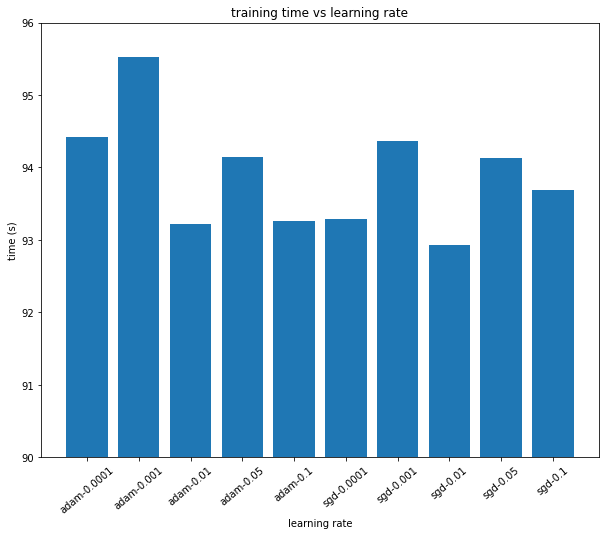

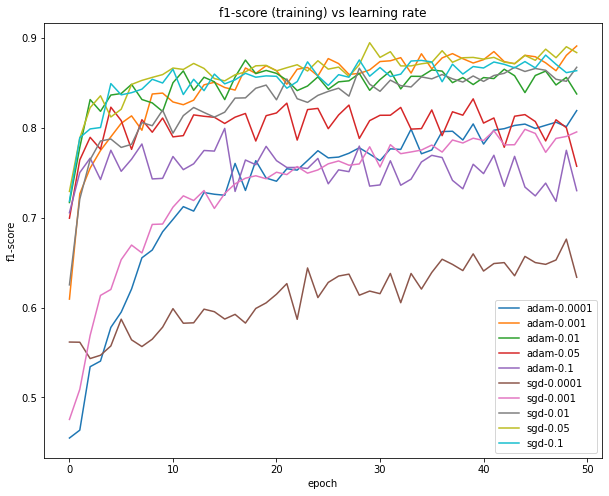

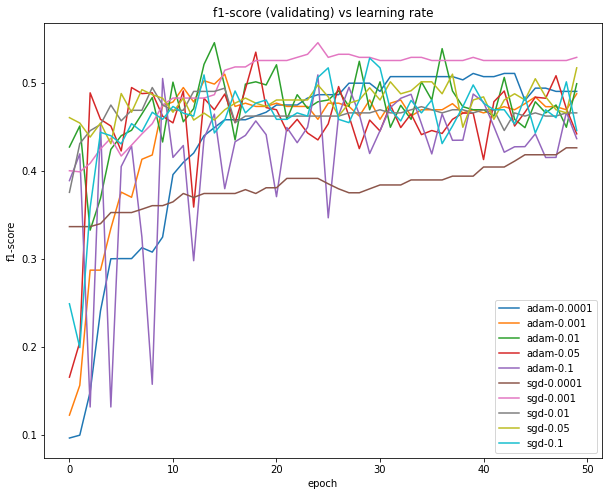

In [ ]:
get_plots(legend=legend,
          training_times=training_times,
          training_f1=training_f1,
          validating_f1=validating_f1)

### Elección mejor modelo

A la vista de los anteriores resultados, podemos apreciar que el modelo que nos proporciona un mayor f1-score presenta las siguientes características:

* Optimizador: SGD.
* Learning-rate: 0.001.

Cabe destacar que este modelo es de los que menos tiempo tarda en entrenarse, además de ser el 4º modelo que menos sobreajusta los datos de entrenamiento, es decir, se consigue el mayor f1-score sobre el conjunto de validación y no se sobreajusta demasiado los datos de entrenamiento.

Por todo lo anterior, se ha utilizado estos parámetros para elegir el modelo final.

Como a priori se desconoce el número de época ideal se va a hacer uso de `EarlyStopping`, se monitoriza la pérdida en validación buscando que sea mínima, si no mejora dicha pérdida en 3 épocas se para el entrenamiento alcanzando la época que sea.

Cabe mencionar que el número total de épocas es 100, es decir, si sigue mejorando el entrenamiento de la red se parará en la época 100.

Definimos el `EarlyStopping` para el modelo 1:

In [19]:
early_stopping_model1 = EarlyStopping(monitor="val_loss", mode="min", patience=3)

Entrenamos la red:

In [20]:
model1 = build_base_model(optimizer="sgd", learning_rate=1e-3)
history_model1 = model1.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model1]
)

Epoch 1/100
22/22 [==============================] - 10s 181ms/step - loss: 0.8856 - get_f1: 0.4831 - val_loss: 0.7363 - val_get_f1: 0.3314
Epoch 2/100
22/22 [==============================] - 3s 115ms/step - loss: 0.7666 - get_f1: 0.5475 - val_loss: 0.7050 - val_get_f1: 0.3370
Epoch 3/100
22/22 [==============================] - 3s 115ms/step - loss: 0.7007 - get_f1: 0.5853 - val_loss: 0.6804 - val_get_f1: 0.3233
Epoch 4/100
22/22 [==============================] - 3s 115ms/step - loss: 0.6771 - get_f1: 0.6089 - val_loss: 0.6589 - val_get_f1: 0.3355
Epoch 5/100
22/22 [==============================] - 3s 115ms/step - loss: 0.6373 - get_f1: 0.6349 - val_loss: 0.6397 - val_get_f1: 0.3736
Epoch 6/100
22/22 [==============================] - 3s 116ms/step - loss: 0.6112 - get_f1: 0.6533 - val_loss: 0.6228 - val_get_f1: 0.3895
Epoch 7/100
22/22 [==============================] - 3s 115ms/step - loss: 0.5979 - get_f1: 0.6666 - val_loss: 0.6066 - val_get_f1: 0.3789
Epoch 8/100
22/22 [=======

### Guardado del modelo

Antes de evaluar el modelo 1 final vamos a realizar el guardado del mismo:

In [23]:
MODEL_NAME = "model1/"
EPOCHS = 69
OPTIMIZER = "sgd"
LEARNING_RATE = 1e-3

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model1.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle/assets


In [24]:
# Guardamos el history del modelo
pickle.dump(history_model1.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Al final de este punto se van a discutir los resultados obtenidos, pero antes vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [26]:
y_probs = model1.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Métodos para graficar la matriz de confusión y la curva ROC junto el AUC:

In [32]:
def plot_confusion_matrix(y_true, y_pred):
  # Matriz de confusion
  matrix = confusion_matrix(y_true, y_pred)

  # Visualización de la matriz de confusión
  # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
  sns.heatmap(matrix, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(list(np.unique(y_pred)))
  ax.yaxis.set_ticklabels(list(np.unique(y_pred)))
  plt.show()

def plot_ROC_AUC(y_true, y_prob):
  fpr, tpr, _ = roc_curve(y_true, y_prob)
  fig, ax1 = plt.subplots(1,1, figsize = (8, 8))
  ax1.plot(fpr, tpr, 'b.-', label = 'AUC:%2.3f' % roc_auc_score(y_test, y_probs))
  ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
  ax1.legend(loc = 4)
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate');
  ax1.set_title('ROC Curve')

Los resultados obtenidos son los siguientes:

In [33]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        82
           1       0.90      0.75      0.82        92

    accuracy                           0.82       174
   macro avg       0.83      0.83      0.82       174
weighted avg       0.83      0.82      0.82       174



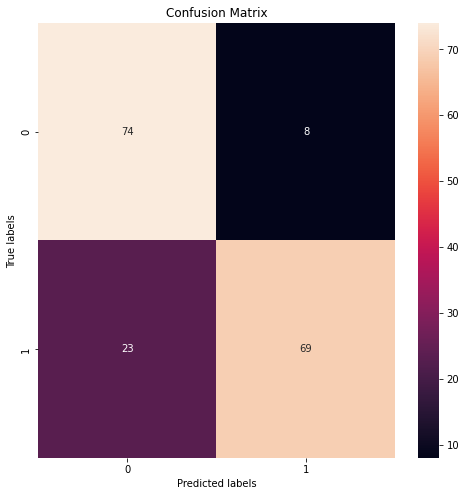

In [34]:
plot_confusion_matrix(y_test, y_preds)

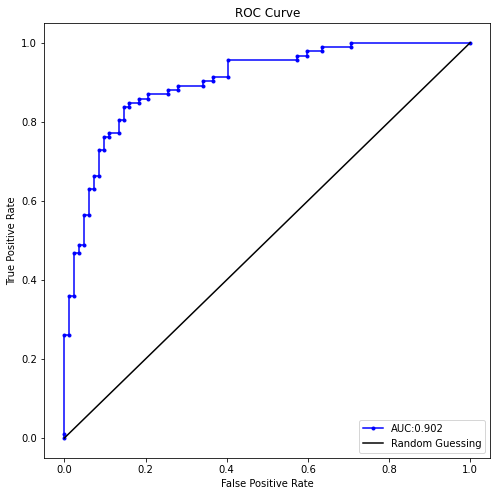

In [35]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Tal y como podemos apreciar en al anterior punto, los resultados obtenidos entrenando solamente el clasificador final son buenos.

En cuanto al informe de clasificación, observamos que se consigue una mayor precisión para los casos en los que hay una anomalía, sin embargo, la sensibilidad (recall) es peor cuando se diagnositca dicha enfermedad. El f1-score obtenido para ambas clases está muy bien, lo ideal es que sea a partir del 0.9, pero consiguiendo estos resultados solamente entrenando el clasificador final son muy buenos.

En el ámbito sanitario se busca diagnoticar una enfermedad, en nuestro caso, el glaucoma de la mejor forma posible. Vemos que este modelo es capaz de identificar de forma casi correcta los falsos positivos, es decir, aquellos casos en los que la red devuelve que hay una anomalía pero en la realidad no es así; esto no suele ser un problema, ya que nos permitiría ser más precavidos. Sin embargo, cuando se realiza el diagnóstico de una enfermedad buscamos reducir los falsos negativos, es decir, los casos en los que se predice como que no hay una enfermedad cuando en la realidad sí que es así.

En este modelo los falsos positvos son 8 para el conjunto de test, tal y como podemos ver en la matriz de confusión, frente a los 23 falsos negativos.

Respecto a la curva ROC y su valor AUC (area under curve), vemos que el valor obtenido es elevado (0.902), es decir, el modelo presenta una proporción correcta entre los falsos positivos y los verdaderos positivos.

Como podemos observar este modelo es bueno, pero se van a realizar otros con el objetivo de mejorar los resultados.


## Modelo 2 - descongelación parcial

### Construcción del modelo

La primero que vamos a hacer es definir el método encargado de generar el modelo (modelo 2 y modelo 3). Cabe destacar que probamos diferentes optimizadores y learning rates para saber cuál se comporta mejor.

In [38]:
def unfreeze_model(model, optimizer="adam", learning_rate=1e-3, type_model="partial"):
  opt = None # optimizer

  # Unfreeze last 20 layers
  if type_model == "partial":
    for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

  elif type_model == "total":
    # Unfreeze all
    for layer in model.layers:
      layer.trainable = True

  # Compile
  if optimizer == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
    opt = SGD(learning_rate=learning_rate)

  model.compile(
      optimizer=opt, loss="binary_crossentropy", metrics=[get_f1]
  )

  return model

### Búsqueda de los hiperparámetros

In [40]:
# Definición de los hiperparámetros
optimizers = ["adam", "sgd"]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
epochs = 50

In [45]:
training_times, training_f1, validating_f1 = gridSearch(optimizers=optimizers, 
                                                        learning_rates=learning_rates, 
                                                        epochs=epochs,
                                                        type_model="partial")

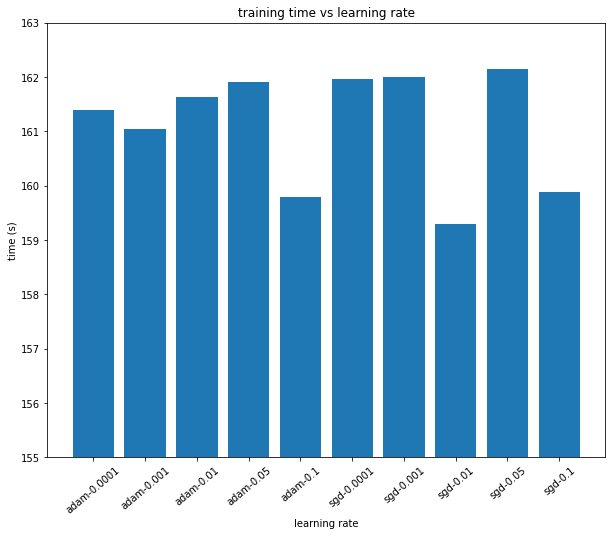

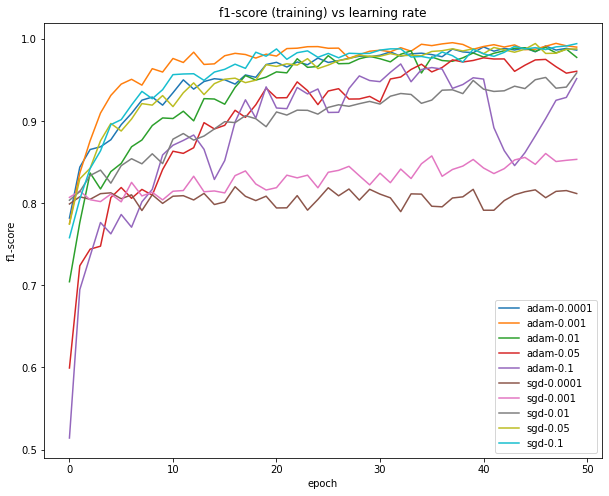

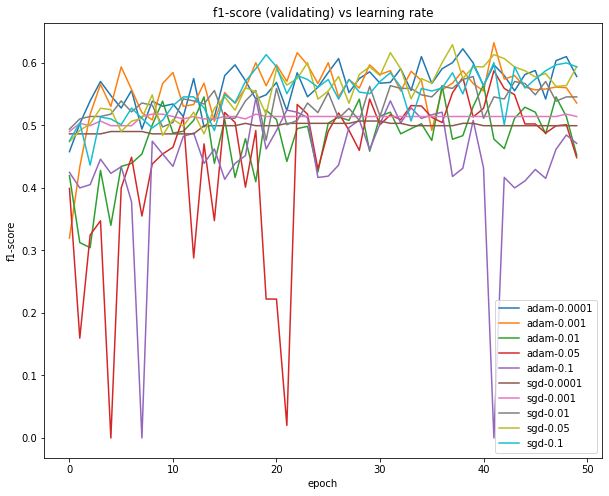

In [56]:
get_plots(legend=legend,
          training_times=training_times,
          training_f1=training_f1,
          validating_f1=validating_f1,
          type_model="partial")

### Elección mejor modelo

A la vista de los anteriores resultados, podemos apreciar que el modelo que nos proporciona un mayor f1-score presenta las siguientes características:

* Optimizador: ADAM.
* Learning-rate: 0.0001.

Cabe destacar que este modelo es uno de los que más tiempo tarda en entrenarse, pero tiende a sobreajustar menos los datos que otros optimizadores con otros learning rates. Es verdad, que en 50 épocas tanto el SGD-0.1 como el SGD-0.05 son los que más f1-score suelen alcanzar a lo largo de todo el entrenamiento, pero el Adam-0.0001 es el que menos tiende a sobreajustar los datos de estos dos.

Por todo lo anterior, se ha utilizado estos parámetros para elegir el modelo final.

Como a priori se desconoce el número de época ideal se va a hacer uso de `EarlyStopping` al igual que sucedía con el modelo anterior. Se va a monitorizar la pérdida en validación buscando que sea mínima, si no mejora dicha pérdida en 3 épocas se para el entrenamiento alcanzando la época que sea.

Cabe mencionar que el número total de épocas es 100, es decir, si sigue mejorando el entrenamiento de la red se parará en la época 100.

Definimos el `EarlyStopping` para el modelo 2:

In [57]:
early_stopping_model2 = EarlyStopping(monitor="val_loss", mode="min", patience=3)

Entrenamos la red:

In [58]:
# Cargamos el modelo 1
model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle", custom_objects={"get_f1": get_f1})

# Descongelamos las últimas 20 capas del modelo 1
model2 = unfreeze_model(model=model_base,
                        optimizer="adam",
                        learning_rate=1e-4,
                        type_model="partial")

# Entrenamos el modelo 2
history_model2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model1]
)

Epoch 1/100
22/22 [==============================] - 10s 195ms/step - loss: 0.4060 - get_f1: 0.8000 - val_loss: 0.4060 - val_get_f1: 0.5024
Epoch 2/100
22/22 [==============================] - 3s 129ms/step - loss: 0.3438 - get_f1: 0.8203 - val_loss: 0.4005 - val_get_f1: 0.5103
Epoch 3/100
22/22 [==============================] - 3s 129ms/step - loss: 0.3089 - get_f1: 0.8500 - val_loss: 0.3485 - val_get_f1: 0.5288
Epoch 4/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2825 - get_f1: 0.8792 - val_loss: 0.3727 - val_get_f1: 0.4864
Epoch 5/100
22/22 [==============================] - 3s 129ms/step - loss: 0.2693 - get_f1: 0.8695 - val_loss: 0.3746 - val_get_f1: 0.5060
Epoch 6/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2520 - get_f1: 0.8986 - val_loss: 0.3195 - val_get_f1: 0.5211
Epoch 7/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2267 - get_f1: 0.9034 - val_loss: 0.3225 - val_get_f1: 0.5179
Epoch 8/100
22/22 [=======

### Guardado del modelo

Antes de evaluar el modelo 2 final vamos a realizar el guardado del mismo:

In [59]:
MODEL_NAME = "model2/"
EPOCHS = 12
OPTIMIZER = "adam"
LEARNING_RATE = 1e-4

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model2.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model2/model_EP12_OPadam_LR0.0001.pickle/assets


In [60]:
# Guardamos el history del modelo
pickle.dump(history_model2.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [61]:
y_probs = model2.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [62]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83        82
           1       0.94      0.71      0.81        92

    accuracy                           0.82       174
   macro avg       0.84      0.83      0.82       174
weighted avg       0.85      0.82      0.82       174



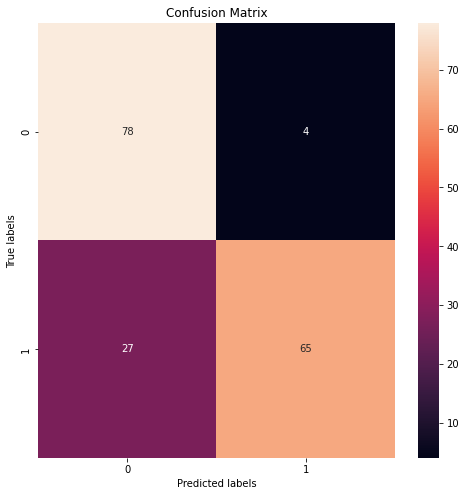

In [63]:
plot_confusion_matrix(y_test, y_preds)

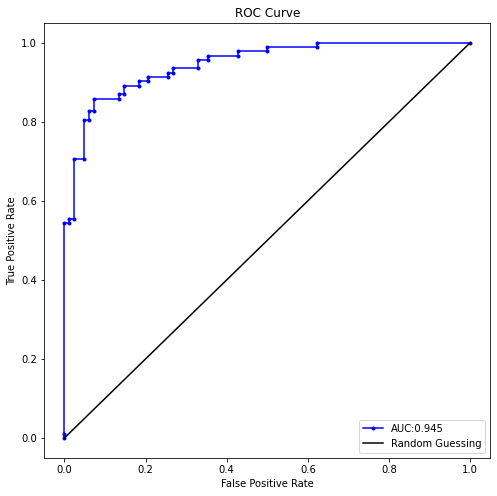

In [64]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados